In [25]:
import glob, os,random
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report, precision_recall_fscore_support
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
import torchvision
from torchsummary import summary

from tqdm import tqdm

import vision_transformer as vits

In [26]:
transformer = 'dino_vit_pretrained' # vit or linformer or sinkhorn or encoder or cait or cvt or cross_vit 
                                    # or tnt or t2t or swin or dino_vit_custom or dino_vit_pretrained or dino_vit_finetuned
crop = True
num_of_tire_to_block = 1
freeze_encoder = False

if crop:
    data_dir = 'cropped'
else:
    data_dir = 'original'

# transformer parameters
img_size = 224
patch_size = 32
num_classes = 13
dim = 1024
depth = 12
heads = 8
mlp_dim = 2048
dropout = 0.1
emb_dropout = 0.1
num_landmarks = 128

# linformer parameters
seq_len = int((img_size/patch_size)**2+1)
k = 64

# sinkhorn parameters
bucket_size = int((img_size/patch_size)**2+1)

# Training settings for sgd
if transformer == 'tnt':
    batch_size_train = 32
    batch_size_test = 32
else:
    batch_size_train = 64
    batch_size_test = 64
if transformer == 'swin':
    lr = 1e-3
else:
    lr = 0.003
if transformer == 'dino_vit_custom' or 'dino_vit_pretrained' or 'dino_vit_finetuned':
    epochs = 30
else:
    epochs = 50
valid_ratio = 0.2
gamma = 0.85
seed = 2
num_workers = 0
device = 'cuda'
# devices = [2,3]
devices = [0,1]
# devices = "cuda:0"

optimizer = 'adam' # sgd or adam

In [27]:
# create a list containing all image file names
train_list = glob.glob(os.path.join('original','*.jpg'))
labels=[]
for root in train_list:
    path = os.path.dirname(root)
    name = root.split("/")[-1].split(".")[0]
    with open(os.path.join(''.join([name,'.txt'])), 'r') as f:
        text = f.read()
        label = int(text.split()[0])+1
        labels.append(label)

# split training set into training and valid.
train_list, valid_list = train_test_split(train_list, 
                        test_size=valid_ratio,
                        stratify=labels
                       ,random_state=seed
                                         )
test_list = valid_list
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(valid_list)}")

Train Data: 6318
Test Data: 1580


In [28]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

def TransformerSelecter(transformer):
    if transformer == 'linformer':
        return linformer
    elif transformer == 'sinkhorn':
        return sinkhorn
    elif transformer == 'encoder':
        return encoder
    else: return False

class trucksDataset(Dataset):
    def __init__(self, file_list, transform, img_resize, train_or_not):
        self.file_list = file_list
        self.transform = transform
        self.resize = img_resize
        self.train_or_not = train_or_not

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        img_height = img_transformed.size(1)
        img_width = img_transformed.size(2)
        name = img_path.split(".")[0]
        path = os.path.dirname(img_path)
        img_name = name.split('\\')[-1]
        img1 = img_transformed
        if self.train_or_not == True:
            if num_of_tire_to_block != 0:
                with open(''.join(['all_images_label/', img_name,'.txt']), 'r') as g:
                    text = g.read()
                    lines = text.split('\n')
                    if len(lines)>2 and lines[0]!='':
                        if num_of_tire_to_block >= len(lines)-2:
                            for i in range(len(lines)-2):
                                x = float(text.split()[(i+1)*5+1])*img_width
                                y = float(text.split()[(i+1)*5+2])*img_height
                                w = float(text.split()[(i+1)*5+3])*img_width
                                h = float(text.split()[(i+1)*5+4])*img_height
                                i = int(x-w/2)
                                j = int(y-h/2)
                                img_transformed = torchvision.transforms.functional.erase(img_transformed, i, j, int(h), int(w), 0)
                        else:
                            tire_idxes = random.sample(list(range(len(lines)-2)), k = num_of_tire_to_block)
#                             print(img_name+'+'+str(len(lines)))
                            for i in tire_idxes:
    #                             print(img_name+'+'+str(len(lines)),tire_idxes)
                                x = float(text.split()[(i+1)*5+1])*img_width
                                y = float(text.split()[(i+1)*5+2])*img_height
                                w = float(text.split()[(i+1)*5+3])*img_width
                                h = float(text.split()[(i+1)*5+4])*img_height
                                i = int(x-w/2)
                                j = int(y-h/2)
                                img_transformed = torchvision.transforms.functional.erase(img_transformed, i, j, int(h), int(w), 0)
#         print(torch.equal(img1, img_transformed))
        with open(''.join([name,'.txt']), 'r') as f:
            text = f.read()
            label = int(text.split()[0])
        if crop:
            x = float(text.split()[1])*img_width
            y = float(text.split()[2])*img_height
            w = int(float(text.split()[3])*img_width)
            h = int(float(text.split()[4])*img_height)
            y1 = int(y-h/2)
            x1 = int(x-w/2)
            img_transformed = torchvision.transforms.functional.crop(img_transformed, y1, x1, h, w)

        img_transformed = self.resize(img_transformed)
        return img_transformed, label


def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    global transformer
    global data_dir
    global img_size
    global patch_size
    global title
    
    seaborn.set(color_codes=True)
    plt.figure(2, figsize=(9, 6))
    
#     title = 'Confusion Matrix: '+transformer + '+Detector (' + data_dir + ') ' + '#_of_patch=' + str(int(img_size/patch_size))
 
    plt.title(title)
 
    seaborn.set(font_scale=1)
    ax = seaborn.heatmap(data, annot=True, fmt='d', cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()

In [29]:
transform = transforms.Compose(
    [        transforms.ToTensor(),
    ]
)

from torchvision import transforms
img_resize = transforms.Resize((img_size, img_size))

train_data = trucksDataset(train_list, transform=transform, img_resize=img_resize, train_or_not=True)
valid_data = trucksDataset(valid_list, transform=transform, img_resize=img_resize, train_or_not=False)
test_data = trucksDataset(test_list, transform=transform, img_resize=img_resize, train_or_not=False)
classifier_data = trucksDataset(train_list, transform=transform, img_resize=img_resize, train_or_not=False)

train_loader = DataLoader(dataset = train_data, batch_size=batch_size_train, shuffle=True, num_workers = num_workers)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size_test, shuffle=False, num_workers = num_workers)
test_loader = DataLoader(dataset = test_data, batch_size=1, shuffle=False, num_workers = num_workers)
classifier_loader = DataLoader(dataset = classifier_data, batch_size=1, shuffle=False, num_workers = num_workers)

print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

6318 99
1580 25


In [30]:
vit = vits.__dict__['vit_small'](patch_size=16)
model = vit.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
if optimizer == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
else:
    if freeze_encoder:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    else:
        optimizer = optim.Adam(model.parameters(), lr=6e-5)
# scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=gamma)

In [31]:
# model.load_state_dict(torch.load('dino_deitsmall16_pretrain.pth', map_location="cpu"), strict = False)
if transformer == 'dino_vit_custom':
    weight_pth = 'logs_cropped/checkpoint.pth'
    epochs = 30
elif transformer == 'dino_vit_pretrained' and crop == True:
    weight_pth = 'dino_deitsmall16_pretrain_full_checkpoint.pth'
    epochs = 15
elif transformer == 'dino_vit_finetuned':
    weight_pth = 'finetuned_logs_cropped/checkpoint.pth'
    epochs = 30
else: weight_pth = 'logs/checkpoint.pth' 

checkpoint = torch.load(weight_pth, map_location="cpu")

state_dict = checkpoint['teacher']
# remove `module.` prefix
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# remove `backbone.` prefix induced by multicrop wrapper
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

In [32]:
model.load_state_dict(state_dict, strict = False)

_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])

In [9]:
if num_of_tire_to_block == 0:
    model_name = transformer+' '+data_dir
else: 
    model_name = transformer+' '+data_dir+' '+str(num_of_tire_to_block)+'-wheel blocked'

min_val_loss = 1
epochs_no_improve = 0

accuracy_train = []
accuracy_test = []
pred_labels = torch.empty(0).to(device)
real_labels = torch.empty(0).to(device)
wrong_data = torch.empty(0).to(device)

for epoch in range(epochs):
#     for param_group in optimizer.param_groups:
#         print(param_group['lr'])
    epoch_loss = 0
    epoch_accuracy = 0
    scheduler.step()
    model.train()
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        model.eval()
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
            if epoch == epochs-1:
                pred_labels = torch.cat((pred_labels, torch.flatten(val_output.argmax(dim=1))))
                real_labels = torch.cat((real_labels, torch.flatten(label)))

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    
    accuracy_train.append(epoch_accuracy.cpu())
    accuracy_test.append(epoch_val_accuracy.cpu())
    
torch.save(model.state_dict(), os.path.join('vit_weights', ''.join([model_name,'.pt'])))

C:\Users\mashi\anaconda3\envs\dino\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Epoch : 1 - loss : 1.1167 - acc: 0.6875 - val_loss : 0.5877 - val_acc: 0.8146



100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Epoch : 2 - loss : 0.5128 - acc: 0.8330 - val_loss : 0.5258 - val_acc: 0.8336



100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Epoch : 3 - loss : 0.3486 - acc: 0.8864 - val_loss : 0.3948 - val_acc: 0.8776



100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Epoch : 4 - loss : 0.2396 - acc: 0.9236 - val_loss : 0.3360 - val_acc: 0.8978



100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Epoch : 5 - loss : 0.1677 - acc: 0.9463 - val_loss : 0.3186 - val_acc: 0.9023



100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Epoch : 6 - loss : 0.1226 - acc: 0.9611 - val_loss : 0.3350 - val_acc: 0.9113



100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Epoch : 7 - loss : 0.0959 - acc: 0.9679 - val_loss : 0.4965 - val_acc: 0.8632



100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Epoch : 8 - loss : 0.0966 - acc: 0.9693 - val_loss : 0.3491 - val_acc: 0.9001



100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


Epoch : 9 - loss : 0.0533 - acc: 0.9831 - val_loss : 0.3623 - val_acc: 0.9003



100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Epoch : 10 - loss : 0.0353 - acc: 0.9904 - val_loss : 0.3709 - val_acc: 0.9182



100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Epoch : 11 - loss : 0.0459 - acc: 0.9855 - val_loss : 0.3864 - val_acc: 0.8951



100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Epoch : 12 - loss : 0.0471 - acc: 0.9840 - val_loss : 0.3632 - val_acc: 0.9100



100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Epoch : 13 - loss : 0.0586 - acc: 0.9826 - val_loss : 0.4270 - val_acc: 0.8845



100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Epoch : 14 - loss : 0.0221 - acc: 0.9924 - val_loss : 0.3725 - val_acc: 0.9222



100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Epoch : 15 - loss : 0.0222 - acc: 0.9923 - val_loss : 0.5117 - val_acc: 0.8891



100%|██████████| 25/25 [00:08<00:00,  2.82it/s]


Epoch : 16 - loss : 0.0178 - acc: 0.9950 - val_loss : 0.5173 - val_acc: 0.8969



100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Epoch : 17 - loss : 0.0220 - acc: 0.9927 - val_loss : 0.4824 - val_acc: 0.9016



100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Epoch : 18 - loss : 0.0286 - acc: 0.9908 - val_loss : 0.5130 - val_acc: 0.8879



100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Epoch : 19 - loss : 0.0391 - acc: 0.9869 - val_loss : 0.4950 - val_acc: 0.8770



100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Epoch : 20 - loss : 0.0177 - acc: 0.9940 - val_loss : 0.3757 - val_acc: 0.9153



100%|██████████| 25/25 [00:08<00:00,  2.81it/s]


Epoch : 21 - loss : 0.0086 - acc: 0.9978 - val_loss : 0.4808 - val_acc: 0.9185



100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Epoch : 22 - loss : 0.0082 - acc: 0.9979 - val_loss : 0.4083 - val_acc: 0.9154



100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Epoch : 23 - loss : 0.0012 - acc: 0.9998 - val_loss : 0.3757 - val_acc: 0.9294



100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


Epoch : 24 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.3775 - val_acc: 0.9326



100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Epoch : 25 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.3795 - val_acc: 0.9332



100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Epoch : 26 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.3826 - val_acc: 0.9338



100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


Epoch : 27 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.3846 - val_acc: 0.9338



100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Epoch : 28 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.3870 - val_acc: 0.9332



100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Epoch : 29 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.3891 - val_acc: 0.9332



100%|██████████| 25/25 [00:08<00:00,  2.83it/s]

Epoch : 30 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.3917 - val_acc: 0.9332



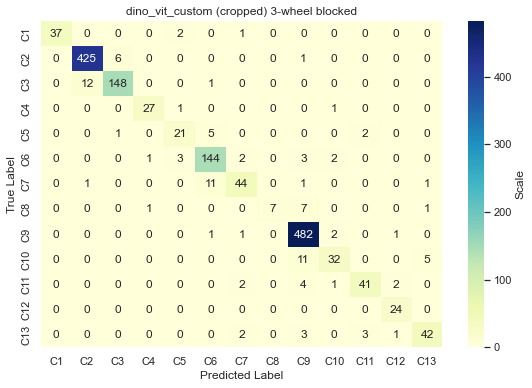

In [10]:
cm = confusion_matrix(real_labels.cpu(), pred_labels.cpu())
title = transformer + ' (' + data_dir + ') ' + str(num_of_tire_to_block) + '-wheel blocked'
classes = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13']
plot_confusion_matrix(cm, classes, 'confusion_matrix/'+title)

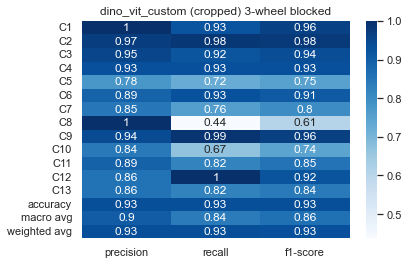

In [11]:
report = classification_report(real_labels.cpu(), pred_labels.cpu(), target_names=classes, digits=3,output_dict=True)
rp = seaborn.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title(title)
plt.savefig(os.path.join('classification_report', ''.join([title,'.png'])),dpi=200, bbox_inches='tight')
report = classification_report(real_labels.cpu(), pred_labels.cpu(), target_names=classes, digits=4,output_dict=False)
with open(os.path.join('c_reports', ''.join([title,'.txt'])), "w+") as output:
    output.write(report)

C:\Users\mashi\anaconda3\envs\dino\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  import sys


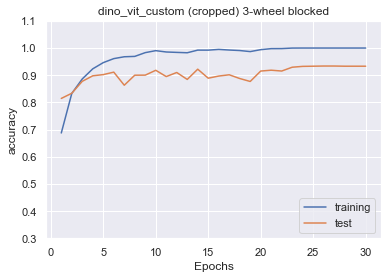

In [12]:
epoch50 = list(range(1,epochs+1))
plt.plot(epoch50, accuracy_train,label='training')
plt.plot(epoch50, accuracy_test,label='test')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.grid(b=True, which='major', color='w', linestyle='-')
plt.ylim([0.3,1.1])
plt.title(title)
plt.axis('on')
plt.savefig(os.path.join('acc_pics', ''.join([title,'.png'])),dpi=120)

In [33]:
if num_of_tire_to_block == 0:
    model_name = transformer+' '+data_dir
else: 
    model_name = transformer+' '+data_dir+' '+str(num_of_tire_to_block)+'-wheel blocked'


import vit_pytorch_new.dino_vit as vits
vit = vits.__dict__['vit_small'](patch_size=16)

model = vit.to(device)

model.load_state_dict(torch.load(os.path.join('vit_weights', ''.join([model_name,'.pt']))), strict = False)
model.eval()

train_features = torch.empty(0).to(device)
test_features = torch.empty(0).to(device)
train_labels = []
test_labels = []

with torch.no_grad():
    for data, label in tqdm(classifier_loader):
        data = data.to(device)
        train_labels.append(label.item())

        val_output = model(data)
        train_features = torch.cat((train_features, val_output))

with torch.no_grad():
    for data, label in tqdm(test_loader):
        data = data.to(device)
        test_labels.append(label.item())

        val_output = model(data)
        test_features = torch.cat((test_features, val_output))

100%|██████████| 1580/1580 [00:23<00:00, 65.98it/s]


In [44]:
if transformer == 'swin':
    dim = 96*8
    tire_multiplier = 2000
elif transformer == 'tnt':
    dim = img_size*2
    tire_multiplier = 2000
elif transformer == 't2t':
    dim = 512
    tire_multiplier = 2000
elif transformer == 'cvt':
    dim = 384
    tire_multiplier = 2000
elif transformer == 'cross_vit':
    dim = 128
    tire_multiplier = 2000
elif transformer == 'dino_vit_custom' or 'dino_vit_pretrained' or 'dino_vit_finetuned':
    dim = 384
    tire_multiplier = 2000
else:
    dim = dim
    tire_multiplier = 1000

add_tire_info = True
max_tire = 13


if add_tire_info:
    # concat ViT features with tire features
    total_train = torch.zeros(len(train_features),dim+max_tire-1)
    total_test = torch.zeros(len(test_features),dim+max_tire-1)

    for f in range(len(train_features)):
        img_name = train_list[f].split('\\')[-1].split('.')[0]
        with open(''.join(['all_images_label/', img_name,'.txt']), 'r') as g:
            text = g.read()
            lines = text.split('\n')
            if lines[0]!='' and len(lines)>2:
                tires_pos = []
                for i in range(len(lines)-2):
                    x = float(text.split()[(i+1)*5+1])
                    tires_pos.append(x)
                tires_pos.sort()
                max_dist = tires_pos[-1] - tires_pos[0]
                relative_dist = []
                for t in range(len(tires_pos)-1):
                    relative_dist.append((tires_pos[t+1]-tires_pos[t])*tire_multiplier/max_dist)
            else:
                relative_dist = [0]
        total_train[f] = torch.cat((train_features[f], 
                            torch.as_tensor(relative_dist).to(device),
                            torch.zeros(max_tire-1-len(relative_dist)).to(device)),0)
 
    for f in range(len(test_features)):
        img_name = test_list[f].split('\\')[-1].split('.')[0]
        with open(''.join(['all_images_label/', img_name,'.txt']), 'r') as g:
            text = g.read()
            lines = text.split('\n')
            if lines[0]!='' and len(lines)>2:
                tires_pos = []
                for i in range(len(lines)-2):
                    x = float(text.split()[(i+1)*5+1])
                    tires_pos.append(x)
                tires_pos.sort()
                max_dist = tires_pos[-1] - tires_pos[0]
                relative_dist = []
                for t in range(len(tires_pos)-1):
                    relative_dist.append((tires_pos[t+1]-tires_pos[t])*tire_multiplier/max_dist)
            else:
                relative_dist = [0]
        total_test[f] = torch.cat((test_features[f], 
                            torch.as_tensor(relative_dist).to(device),
                            torch.zeros(max_tire-1-len(relative_dist)).to(device)),0)

In [45]:
from vit_pytorch_new.MLP import MLP

input_features = total_train.size()[1]
model = MLP(input_features=input_features, num_classes = num_classes).to(device)
print(input_features)

396


In [46]:
class featuresData(Dataset):
    def __init__(self, tensors, labels,transform=None):
        self.tensors = tensors
        self.transform = transform
        self.labels = labels

    def __len__(self):
        self.tensorslength = len(self.tensors)
        return self.tensorslength

    def __getitem__(self, idx):
        tensor = self.tensors[idx]
        label = self.labels[idx]
        return tensor, label

In [47]:
# Dataloaders for MLP
train_tensors = featuresData(total_train, transform= None, labels = train_labels)
total_train_loader = DataLoader(dataset = train_tensors, batch_size=32, shuffle=True)

test_tensors = featuresData(total_test, transform= None, labels = test_labels)
total_test_loader = DataLoader(dataset = test_tensors, batch_size=32, shuffle=False)
print(len(train_tensors), len(total_train_loader))
print(len(test_tensors), len(total_test_loader))

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

6318 198
1580 50


In [48]:
epochs = 50
break_limit = 0.97
accuracy_train = []
accuracy_test = []
pred_labels = torch.empty(0).to(device)
real_labels = torch.empty(0).to(device)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    model.train()
    for data, label in tqdm(total_train_loader):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, label)

        
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(total_train_loader)
        epoch_loss += loss / len(total_train_loader)

    with torch.no_grad():
        model.eval()
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(total_test_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(total_test_loader)
            epoch_val_loss += val_loss / len(total_test_loader)
            if epoch == epochs-1:
                pred_labels = torch.cat((pred_labels, torch.flatten(val_output.argmax(dim=1))))
                real_labels = torch.cat((real_labels, torch.flatten(label)))    
                
                
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    
    accuracy_train.append(epoch_accuracy.cpu())
    accuracy_test.append(epoch_val_accuracy.cpu())
    
    if epoch_val_accuracy > break_limit:
        with torch.no_grad():
            model.eval()
            for data, label in tqdm(total_test_loader):
                data = data.to(device)
                label = label.to(device)
                val_output = model(data)
                pred_labels = torch.cat((pred_labels, torch.flatten(val_output.argmax(dim=1))))
                real_labels = torch.cat((real_labels, torch.flatten(label)))    
        break
    
# torch.save(model.state_dict(), os.path.join('mlp_weights', ''.join([model_name,'.pt'])))

100%|██████████| 50/50 [00:00<00:00, 1562.50it/s]


Epoch : 1 - loss : 1.2207 - acc: 0.7019 - val_loss : 0.4893 - val_acc: 0.8600



100%|██████████| 50/50 [00:00<00:00, 1470.58it/s]


Epoch : 2 - loss : 0.9356 - acc: 0.8600 - val_loss : 0.2814 - val_acc: 0.9356



100%|██████████| 50/50 [00:00<00:00, 1515.11it/s]


Epoch : 3 - loss : 0.8045 - acc: 0.9300 - val_loss : 0.2336 - val_acc: 0.9475



100%|██████████| 50/50 [00:00<00:00, 1515.58it/s]


Epoch : 4 - loss : 0.7872 - acc: 0.9463 - val_loss : 0.2760 - val_acc: 0.9575



100%|██████████| 50/50 [00:00<00:00, 1515.17it/s]


Epoch : 5 - loss : 0.4156 - acc: 0.9645 - val_loss : 0.3075 - val_acc: 0.9644



100%|██████████| 50/50 [00:00<00:00, 1612.90it/s]


Epoch : 6 - loss : 0.3512 - acc: 0.9744 - val_loss : 0.3001 - val_acc: 0.9588



100%|██████████| 50/50 [00:00<00:00, 1562.14it/s]


Epoch : 7 - loss : 0.3055 - acc: 0.9721 - val_loss : 0.5696 - val_acc: 0.9556



100%|██████████| 50/50 [00:00<00:00, 1562.65it/s]


Epoch : 8 - loss : 0.2840 - acc: 0.9732 - val_loss : 0.4227 - val_acc: 0.9556



100%|██████████| 50/50 [00:00<00:00, 1517.11it/s]


Epoch : 9 - loss : 0.5281 - acc: 0.9740 - val_loss : 0.3081 - val_acc: 0.9619



100%|██████████| 50/50 [00:00<00:00, 1514.35it/s]


Epoch : 10 - loss : 0.3639 - acc: 0.9761 - val_loss : 0.5864 - val_acc: 0.9550



100%|██████████| 50/50 [00:00<00:00, 1562.51it/s]


Epoch : 11 - loss : 0.2342 - acc: 0.9759 - val_loss : 0.3396 - val_acc: 0.9688



100%|██████████| 50/50 [00:00<00:00, 1562.50it/s]


Epoch : 12 - loss : 0.2103 - acc: 0.9814 - val_loss : 0.5565 - val_acc: 0.9594



100%|██████████| 50/50 [00:00<00:00, 1513.72it/s]


Epoch : 13 - loss : 0.1752 - acc: 0.9880 - val_loss : 0.5930 - val_acc: 0.9656



100%|██████████| 50/50 [00:00<00:00, 1514.98it/s]


Epoch : 14 - loss : 0.2839 - acc: 0.9850 - val_loss : 0.7130 - val_acc: 0.9619



100%|██████████| 50/50 [00:00<00:00, 1562.85it/s]


Epoch : 15 - loss : 0.1778 - acc: 0.9793 - val_loss : 0.6085 - val_acc: 0.9575



100%|██████████| 50/50 [00:00<00:00, 1562.66it/s]


Epoch : 16 - loss : 0.2544 - acc: 0.9837 - val_loss : 0.6451 - val_acc: 0.9600



100%|██████████| 50/50 [00:00<00:00, 1562.54it/s]


Epoch : 17 - loss : 0.2486 - acc: 0.9811 - val_loss : 0.4893 - val_acc: 0.9575



100%|██████████| 50/50 [00:00<00:00, 1560.50it/s]


Epoch : 18 - loss : 0.1658 - acc: 0.9844 - val_loss : 1.0665 - val_acc: 0.9425



100%|██████████| 50/50 [00:00<00:00, 1515.35it/s]


Epoch : 19 - loss : 0.1566 - acc: 0.9855 - val_loss : 0.7946 - val_acc: 0.9625



100%|██████████| 50/50 [00:00<00:00, 1470.93it/s]


Epoch : 20 - loss : 0.1541 - acc: 0.9807 - val_loss : 0.5895 - val_acc: 0.9675



100%|██████████| 50/50 [00:00<00:00, 1515.50it/s]


Epoch : 21 - loss : 0.2550 - acc: 0.9842 - val_loss : 0.7099 - val_acc: 0.9600



100%|██████████| 50/50 [00:00<00:00, 1562.67it/s]


Epoch : 22 - loss : 0.1233 - acc: 0.9877 - val_loss : 0.6046 - val_acc: 0.9656



100%|██████████| 50/50 [00:00<00:00, 1515.81it/s]


Epoch : 23 - loss : 0.3081 - acc: 0.9882 - val_loss : 0.5390 - val_acc: 0.9631



100%|██████████| 50/50 [00:00<00:00, 1470.56it/s]


Epoch : 24 - loss : 0.1104 - acc: 0.9875 - val_loss : 0.5395 - val_acc: 0.9638



100%|██████████| 50/50 [00:00<00:00, 1514.78it/s]


Epoch : 25 - loss : 0.3179 - acc: 0.9875 - val_loss : 0.5922 - val_acc: 0.9644



100%|██████████| 50/50 [00:00<00:00, 1514.98it/s]


Epoch : 26 - loss : 0.0834 - acc: 0.9855 - val_loss : 0.8583 - val_acc: 0.9613



100%|██████████| 50/50 [00:00<00:00, 1562.45it/s]


Epoch : 27 - loss : 0.0994 - acc: 0.9869 - val_loss : 0.8512 - val_acc: 0.9538



100%|██████████| 50/50 [00:00<00:00, 1515.16it/s]


Epoch : 28 - loss : 0.0730 - acc: 0.9901 - val_loss : 0.6816 - val_acc: 0.9588



100%|██████████| 50/50 [00:00<00:00, 1470.45it/s]


Epoch : 29 - loss : 0.2884 - acc: 0.9856 - val_loss : 0.6495 - val_acc: 0.9619



100%|██████████| 50/50 [00:00<00:00, 1517.29it/s]


Epoch : 30 - loss : 0.1811 - acc: 0.9884 - val_loss : 0.7761 - val_acc: 0.9600



100%|██████████| 50/50 [00:00<00:00, 1428.00it/s]


Epoch : 31 - loss : 0.1457 - acc: 0.9912 - val_loss : 0.7710 - val_acc: 0.9706



100%|██████████| 50/50 [00:00<00:00, 1783.11it/s]


In [55]:
# torch.flatten(val_output.argmax(dim=1))
val_output

tensor([[-6.1576e+01, -7.0731e+01, -4.8886e+01, -4.3742e+01, -3.9585e+01,
         -4.0010e+01, -6.6736e+01, -1.7996e+01,  8.1717e+01, -3.6302e+01,
         -4.5089e+01, -4.3245e+01, -3.6039e+01],
        [-2.0839e+01,  5.4716e+01, -2.4129e+01, -1.8710e+01, -2.7458e+01,
         -5.4775e+01, -2.1113e+01, -2.7626e+01, -4.5609e+01, -3.3577e+01,
         -3.2040e+01, -2.4527e+01, -1.6755e+01],
        [-2.4420e+01,  5.5053e+01, -2.5075e+01, -2.2578e+01, -2.9226e+01,
         -5.2882e+01, -1.5987e+01, -2.7445e+01, -4.7269e+01, -3.5989e+01,
         -3.0418e+01, -2.5499e+01, -1.3403e+01],
        [-2.6887e+01,  7.2932e+01, -3.4636e+01, -2.6938e+01, -3.8980e+01,
         -7.2617e+01, -2.5962e+01, -3.8702e+01, -6.1077e+01, -4.4065e+01,
         -4.1497e+01, -3.2010e+01, -2.0264e+01],
        [-6.1723e+02,  1.2797e+03, -1.0135e+02, -7.2363e+02, -8.0844e+02,
         -1.2767e+03, -5.8940e+02, -8.1471e+02, -1.3637e+03, -9.1777e+02,
         -9.3671e+02, -7.4753e+02, -5.0828e+02],
        [-3.591

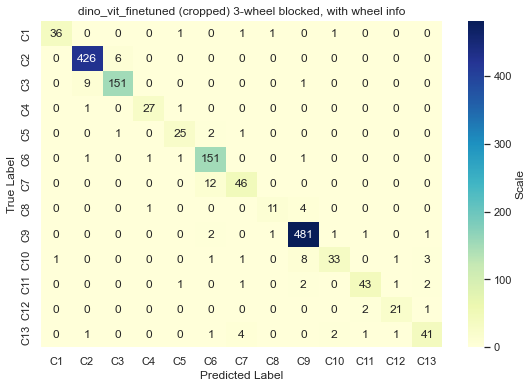

In [15]:
cm = confusion_matrix(real_labels.cpu(), pred_labels.cpu())
title = transformer + ' (' + data_dir + ') ' + str(num_of_tire_to_block) + '-wheel blocked'+ ', with wheel info'
classes = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13']
plot_confusion_matrix(cm, classes, 'confusion_matrix/'+title)

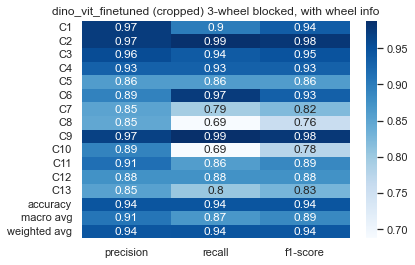

In [16]:
report = classification_report(real_labels.cpu(), pred_labels.cpu(), target_names=classes, digits=3,output_dict=True)
rp = seaborn.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title(title)
plt.savefig(os.path.join('classification_report', ''.join([title,'.png'])),dpi=200, bbox_inches='tight')
report = classification_report(real_labels.cpu(), pred_labels.cpu(), target_names=classes, digits=4,output_dict=False)
with open(os.path.join('c_reports', ''.join([title,'.txt'])), "w+") as output:
    output.write(report)